# LogitBoost via XGBoost vs Neural Net

**Dataset:** UCI Red Wine Quality (binary target: 0 = low (≤5), 1 = high (>5))

**Goal:** Develop LogitBoost using XGBoost and compare the performance with a dense neural network.


## Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import xgboost as xgb

## 2.0 Load & Preprocess

Train: (1119, 11) Test: (480, 11)


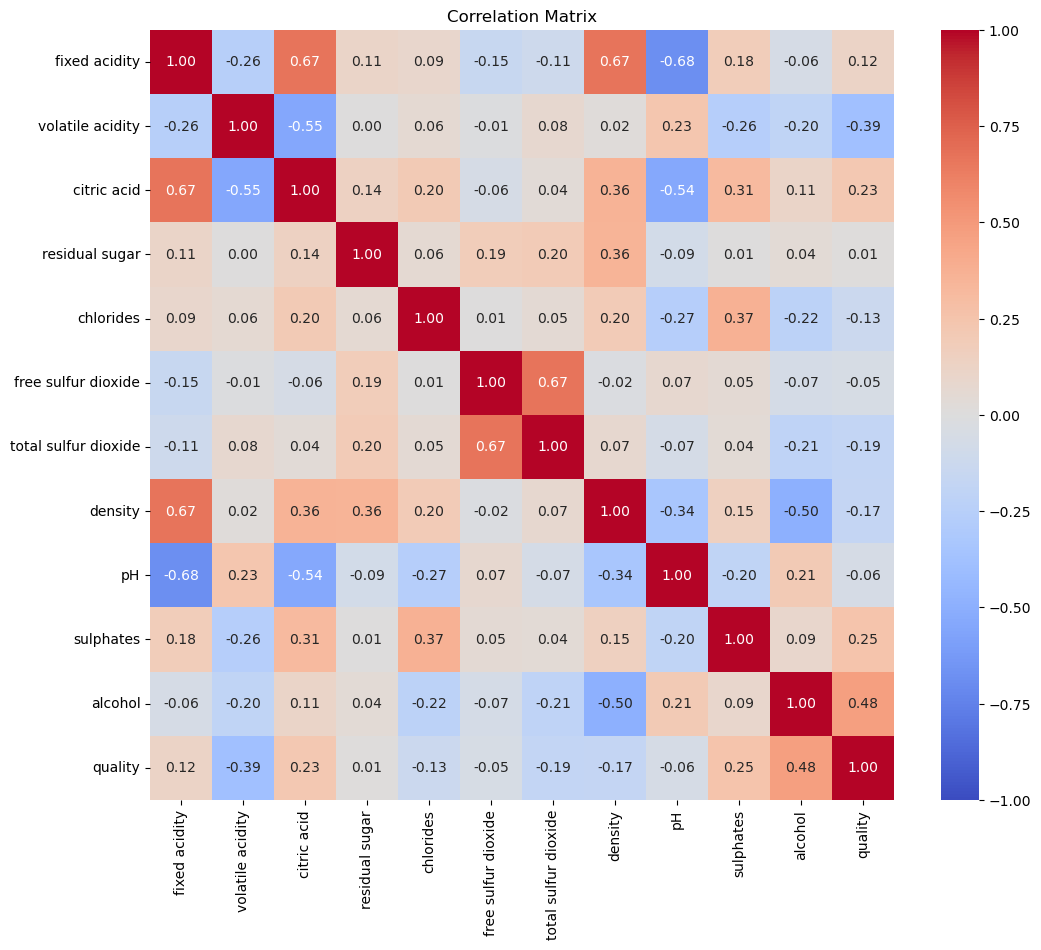

In [28]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')
X = df.drop('quality', axis=1).values
y = df['quality'].apply(lambda x: 1 if x > 5 else 0).values  # Binary


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## 2.1 Baseline: Decision Tree

In [29]:
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("DT Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

DT Accuracy: 0.7208333333333333
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       223
           1       0.76      0.70      0.73       257

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.72      0.72      0.72       480



## 2.2 LogitBoost via XGBoost

In Friedman et al.’s original LogitBoost paper, each boosting “weak learner” is a regression stump (a one‐split tree).

**Reference:**: Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. “Additive logistic regression: a statistical view of boosting.” The annals of statistics 28.2 (2000): 337-407.

In [30]:
xgb_logit = xgb.XGBClassifier(
    objective='binary:logistic',   # logistic loss
    max_depth=1,                   # stumps → classic LogitBoost
    learning_rate=1.0,             # full Newton step
    n_estimators=50,
    eval_metric='logloss',
    random_state=0
)

xgb_logit.fit(X_train, y_train)
y_proba_xgb = xgb_logit.predict_proba(X_test)[:,1]
y_pred_xgb  = (y_proba_xgb > 0.5).astype(int)

print("XGB-LogitBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGB-LogitBoost ROC AUC:  ", roc_auc_score(y_test, y_proba_xgb))

XGB-LogitBoost Accuracy: 0.74375
XGB-LogitBoost ROC AUC:   0.8337491929995987


## 2.3 Neural Network

In [31]:
mlp = MLPClassifier(
    hidden_layer_sizes=(50,30),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=0
)
mlp.fit(X_train, y_train)
y_proba_nn = mlp.predict_proba(X_test)[:,1]
y_pred_nn  = mlp.predict(X_test)

print("MLP Accuracy:  ", accuracy_score(y_test, y_pred_nn))
print("MLP ROC AUC:   ", roc_auc_score(y_test, y_proba_nn))

MLP Accuracy:   0.7125
MLP ROC AUC:    0.805604508733053


## 2.4 ROC Curves Comparison

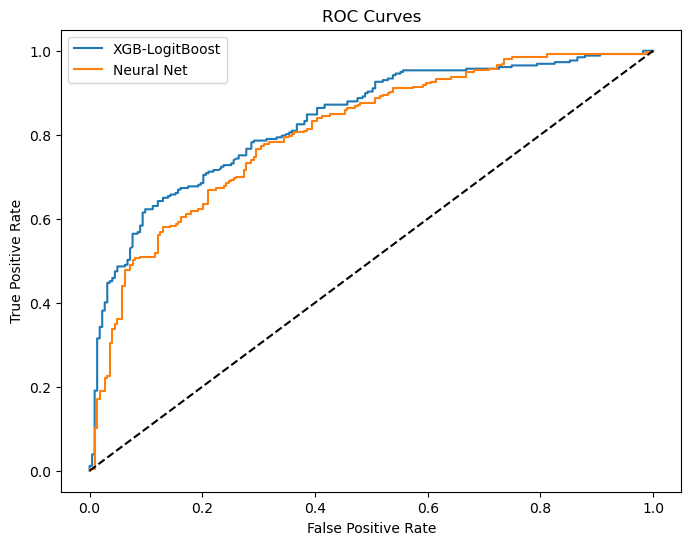

In [32]:
plt.figure(figsize=(8,6))
for name, proba in [
    ('XGB-LogitBoost', y_proba_xgb),
    ('Neural Net',     y_proba_nn)
]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Discussion & Next Steps

- Which model achieved the best accuracy and AUC?
- Did the full‐step LogitBoost overfit?  Try smaller learning_rate.
- Explore hyperparameter tuning via GridSearchCV.